<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Format" data-toc-modified-id="Format-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#cooccur()" data-toc-modified-id="cooccur()-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><code>cooccur()</code></a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Saving results</a></span></li></ul></li><li><span><a href="#Summarizing-results" data-toc-modified-id="Summarizing-results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summarizing results</a></span><ul class="toc-item"><li><span><a href="#Formatting" data-toc-modified-id="Formatting-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Formatting</a></span><ul class="toc-item"><li><span><a href="#Effect-sizes" data-toc-modified-id="Effect-sizes-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Effect sizes</a></span></li><li><span><a href="#Taxonomy" data-toc-modified-id="Taxonomy-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Taxonomy</a></span></li><li><span><a href="#Combining" data-toc-modified-id="Combining-7.1.3"><span class="toc-item-num">7.1.3&nbsp;&nbsp;</span>Combining</a></span></li></ul></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#D3network" data-toc-modified-id="D3network-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>D3network</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Run `cooccur()` on binomial OTU data

# Var

In [45]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# params
sparsity_cutoff = 0.05
qval_cutoff = 0.01 

# Init

In [3]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(igraph)
library(phyloseq)
library(networkD3)
library(cooccur)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following object is masked from ‘package:tidyr’:

    crossing

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [4]:
make_dir(work_dir)

Created directory: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur/ 


## Functions

In [5]:
plot.cooccur <- function(x, text_size=4, ...){
  ##
  allargs <- match.call(expand.dots = TRUE)
  plotrand <- allargs$plotrand
    plotrand <- ifelse(test = is.null(plotrand),yes = FALSE,no = plotrand)
  randsummary<- allargs$randsummary
    randsummary <- ifelse(test = is.null(randsummary),yes = FALSE,no = randsummary)

  ##
  
  dim <- x$species
  comat_pos <- comat_neg <- matrix(nrow=dim,ncol=dim)
  
  co_tab <- x$result
  for (i in 1:nrow(co_tab)){
    comat_pos[co_tab[i,"sp1"],co_tab[i,"sp2"]] <- co_tab[i,"p_gt"]
    comat_pos[co_tab[i,"sp2"],co_tab[i,"sp1"]] <- co_tab[i,"p_gt"]
    
    row.names(comat_pos[co_tab[i,"sp2"],co_tab[i,"sp1"]])
    
  }
  for (i in 1:nrow(co_tab)){
    comat_neg[co_tab[i,"sp1"],co_tab[i,"sp2"]] <- co_tab[i,"p_lt"]
    comat_neg[co_tab[i,"sp2"],co_tab[i,"sp1"]] <- co_tab[i,"p_lt"]
  }
  comat <- ifelse(comat_pos>=0.05,0,1) + ifelse(comat_neg>=0.05,0,-1)
  colnames(comat) <- 1:dim
  row.names(comat) <- 1:dim
  
  if ("spp_key" %in% names(x)){
    
    sp1_name <- merge(x=data.frame(order=1:length(colnames(comat)),sp1=colnames(comat)),y=x$spp_key,by.x="sp1",by.y="num",all.x=T)
    sp2_name <- merge(x=data.frame(order=1:length(row.names(comat)),sp2=row.names(comat)),y=x$spp_key,by.x="sp2",by.y="num",all.x=T)
    
    colnames(comat) <- sp1_name[with(sp1_name,order(order)),"spp"]  
    row.names(comat) <- sp2_name[with(sp2_name,order(order)),"spp"]
      
  }  
  
  #ind <- apply(comat, 1, function(x) all(is.na(x)))
  #comat <- comat[!ind,]
  #ind <- apply(comat, 2, function(x) all(is.na(x)))
  #comat <- comat[,!ind]

  comat[is.na(comat)] <- 0
  
  origN <- nrow(comat)
  
  # SECTION TO REMOVE SPECIES INTERACTION WITH NO OTHERS

  #rmrandomspp <- function(orimat,plotrand = FALSE,randsummary = FALSE){
  if(plotrand == FALSE){
    ind <- apply(comat, 1, function(x) all(x==0))
    comat <- comat[!ind,]    
    ind <- apply(comat, 2, function(x) all(x==0))
    comat <- comat[,!ind]
    #ind <- apply(orimat, 1, function(x) all(x==0))
    #orimat <- orimat[!ind,]    
    #ind <- apply(orimat, 2, function(x) all(x==0))
    #orimat <- orimat[,!ind]
  }
  #return(orimat)
  #}
  
  #comat <- rmrandomspp(orimat = comat, dots)
  ####################################################### 

  postN <- nrow(comat)


  comat <- comat[order(rowSums(comat)),]
  comat <- comat[,order(colSums(comat))]
  
  #comat <- rmrandomspp(orimat = comat, ...)
  
  #ind <- apply(comat, 1, function(x) all(x==0))
  #comat <- comat[!ind,]
  #ind <- apply(comat, 2, function(x) all(x==0))
  #comat <- comat[,!ind]
  
  ind <- apply(comat, 1, function(x) all(x==0))
  comat <- comat[names(sort(ind)),]
  ind <- apply(comat, 2, function(x) all(x==0))
  comat <- comat[,names(sort(ind))]
  
  #comat
  data.m = reshape2::melt(comat)
  colnames(data.m) <- c("X1","X2","value")
  data.m$X1 <- as.character(data.m$X1)
  data.m$X2 <- as.character(data.m$X2)
 
  meas <- as.character(unique(data.m$X2))

  dfids <- subset(data.m, X1 == X2)
  
  X1 <- data.m$X1
  X2 <- data.m$X2
  
  df.lower = subset(data.m[lower.tri(comat),],X1 != X2)
  
  ##### testing the rand summary
    if(randsummary == FALSE){  
      }else{
        dim <- nrow(comat)
        ext.dim <- round(dim*0.2,digits = 0)
          if(ext.dim<0){ext.dim<-1}
        placehold <- paste("ext_", rep(c(1:ext.dim),each = dim), sep="")
      
        randcol.df <- data.frame(
          X1 = placehold,
          X2 = rep(meas,times = ext.dim),
          value = rep(x = c(-2), times = dim*ext.dim))
        
        df.lower <- rbind(df.lower,randcol.df)
        meas <- c(meas,unique(placehold))
      }

  


  #####

  X1 <- df.lower$X1
  X2 <- df.lower$X2
  value <- df.lower$value
 


  ####
 if(randsummary == FALSE){  
    p <- ggplot(df.lower, aes(X1, X2)) + 
         geom_tile(aes(fill = factor(value,levels=c(-1,0,1))), colour ="white") 
    p <- p + scale_fill_manual(values = c("#FFCC66","dark gray","light blue"), name = "", labels = c("negative","random","positive"),drop=FALSE) + 
        theme(axis.text.x = element_blank(),axis.text.y = element_blank(),axis.ticks = element_blank(),plot.title = element_text(vjust=-4,size=20, face="bold"),panel.background = element_rect(fill='white', colour='white'),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = c(0.9, 0.5),legend.text=element_text(size=18)) + 
        ggtitle("Species Co-occurrence Matrix") + 
        xlab("") + ylab("") + 
        scale_x_discrete(limits=meas, expand = c(0.3, 0),drop=FALSE) + 
        scale_y_discrete(limits=meas, expand = c(0.3, 0),drop=FALSE) 
     p <- p + geom_text(data=dfids,aes(label=X1),
                hjust=1,vjust=0,angle = -22.5,  size=text_size)
 
   
 }else{
        
    p <- ggplot(df.lower, aes(X1, X2)) + 
         geom_tile(aes(fill = factor(value,levels=c(-1,0,1,-2))), colour ="white") 
    p <- p + scale_fill_manual(values = c("#FFCC66","dark gray","light blue","light gray"), 
                            name = "", 
                            labels = c("negative","random","positive","random"),drop=FALSE) + 
    theme(axis.text.x = element_blank(),axis.text.y = element_blank(),axis.ticks = element_blank(),plot.title = element_text(vjust=-4,size=20, face="bold"),panel.background = element_rect(fill='white', colour='white'),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = c(0.9, 0.5),legend.text=element_text(size=18)) + 
    ggtitle("Species Co-occurrence Matrix") + 
    xlab("") + ylab("") + 
    scale_x_discrete(limits=meas, expand = c(0.3, 0),drop=FALSE) + 
    scale_y_discrete(limits=meas, expand = c(0.3, 0),drop=FALSE) 
    p <- p + geom_text(data=dfids,
                    aes(label=X1),
                    hjust=1,vjust=0,angle = -22.5, size=text_size)
 
 dim <- nrow(comat)
 ext_x <- dim + 0.5 #(ext.dim/2)
 ext_y <- dim + 1
 nrem <- origN - postN
 randtext <- paste(nrem, " completely\nrandom species")
 ext_dat <- data.frame(ext_x=ext_x,ext_y=ext_y,randtext=randtext)

  p <- p + geom_text(data=ext_dat,
                     aes(x = ext_x,y = ext_y,label=randtext),
                     hjust=0,vjust=0, color="dark gray", size=text_size)
}
 ####
 
 p
 
}

# Load

In [6]:
# phyloseq object (binomial)
physeq = readRDS(physeq_file) %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) %>%
    transform_sample_counts(function(x) ifelse(x > 0, 1, 0)) 
    
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [7]:
# metadata
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(collection_date = collection_date %>% as.character,
           collection_date = as.Date(collection_date, format='%m/%d/%y'),
           collection_bin = ntile(collection_date, 10),
           latitude = latitude %>% as.Num, 
           longitude = longitude %>% as.Num) %>%
    dplyr::select(X.SampleID, scientific_name, class, order, family, genus, diet)

metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213   7


X.SampleID,scientific_name,class,order,family,genus,diet
X1.Eurasian.Beaver,Castor_fiber,Mammalia,Rodentia,Castoridae,Castor,herbivore
X101.Horse,Equus_caballus,Mammalia,Perissodactyla,Equidae,Equus,herbivore
X102.Kulan,Equus_hemionus,Mammalia,Perissodactyla,Equidae,Equus,herbivore


# Format

In [8]:
otu = physeq %>%
    otu_table %>%
    as.matrix %>%
    as.data.frame %>%
    as.data.frame

tax = NULL
otu %>% status

[1] 408 213


,X1.Eurasian.Beaver,X101.Horse,X102.Kulan,X109.Red.Fox,X110.Noctule,X111.West.European.Hedgehog,X116.Common.Kestrel,X122.Wild.Boar,X123.Alpine.Chamois,X124.Golden.Jackal,⋯,F45.Red.Deer,F47.Red.Deer,F48.Red.Deer,F53.Mouflon,F66.Wild.Boar,F68.Red.Deer,F69.Red.Deer,F70.Red.Deer,F80.Red.Deer,F90.Domestic.Dog
368bd5c2255f3a5ce0fef06ca6de1d04,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
779324e5648460c5a67e577c45131b42,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
b918d185ee89a0b33d821ee766d76eb3,0,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,0,1,1,1,1,0


In [9]:
rowSums(otu) %>% summary
colSums(otu) %>% summary

otu_f = otu[rowSums(otu) > 0,colSums(otu) > 0]

rowSums(otu) %>% summary
colSums(otu) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.00   12.00   13.00   14.89   16.00   76.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.00   10.00   28.53   21.00  206.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.00   12.00   13.00   14.89   16.00   76.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.00   10.00   28.53   21.00  206.00 

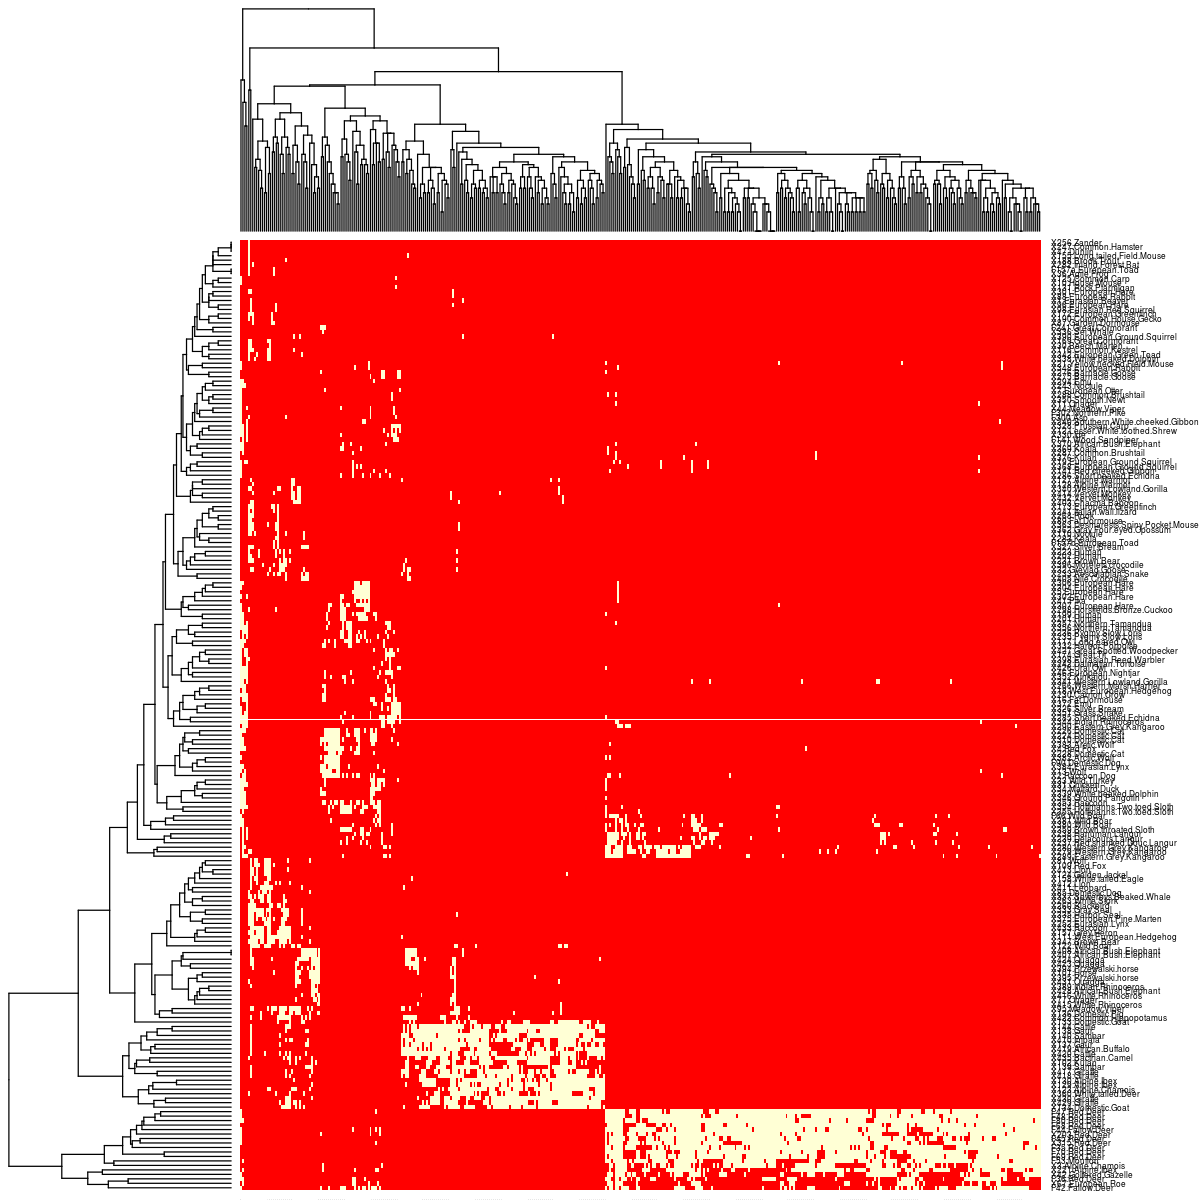

In [14]:
# heatmap of OTU pres/abs
options(repr.plot.height=10, repr.plot.width=10)
heatmap(otu_f %>% as.matrix %>% t, 
        cexCol = 0.001, cexRow = 0.5,
        margins=c(0.5, 8), scale='none')

# `cooccur()`

In [15]:
# cooccurence analysis
## WARNING: SLOW!
cooccur_res = cooccur(mat=otu_f,
                      type="spp_site",
                      thresh=TRUE,
                      spp_names=TRUE)

cooccur_res %>% summary

  |===================================================                   |  73%

limit_output extension: Maximum message size of 20000 exceeded with 20160 characters

In [17]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/5_assembly/cooccur/01_IndD_OTU-binom.ipynb')


## Saving results

In [18]:
# output file name
cooccur_res_file = file.path(work_dir, 'IndD_OTU-cooccur.RDS')
cooccur_res_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD_OTU-cooccur.RDS"

In [19]:
# saving
saveRDS(cooccur_res, file=cooccur_res_file)
cat('File written:', cooccur_res_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD_OTU-cooccur.RDS 


In [20]:
# loading
cooccur_res = readRDS(cooccur_res_file)
cooccur_res %>% summary

Call:
cooccur(mat = otu_f, type = "spp_site", thresh = TRUE, spp_names = TRUE)

Of 83028 species pair combinations, 54630 pairs (65.8 %) were removed from the analysis because expected co-occurrence was < 1 and 28398 pairs were analyzed

Cooccurrence Summary:


       Species          Sites       Positive       Negative         Random 
           408            212           9827            977          17594 
Unclassifiable Non-random (%) 
             0             38 
attr(,"class")
[1] "summary.cooccur"

# Summarizing results

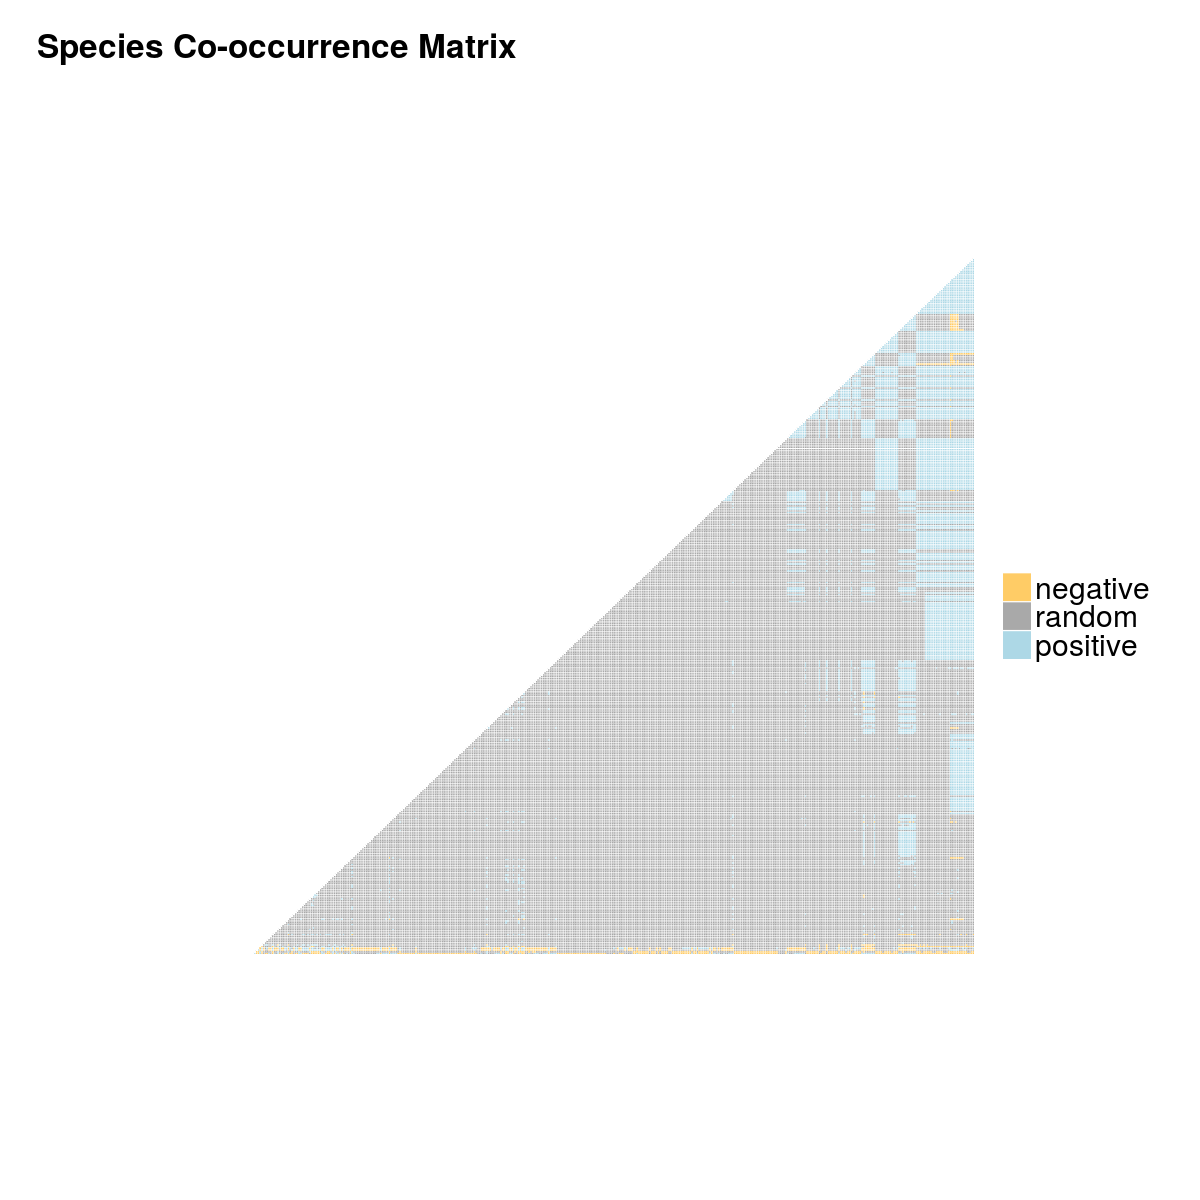

In [21]:
plot.cooccur(cooccur_res, text_size=0.01)

## Formatting

### Effect sizes

In [22]:
# output file name
effect_size_file = file.path(work_dir, 'IndD_OTU-cooccur_effectSizes.RDS')
effect_size_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD_OTU-cooccur_effectSizes.RDS"

In [23]:
# effect sizes
## WARNING: SLOW
eff = cooccur_res %>%
    effect.sizes

eff %>% status

[1] 28398     3


sp1,sp2,effects
368bd5c2255f3a5ce0fef06ca6de1d04,b918d185ee89a0b33d821ee766d76eb3,-0.006132075
368bd5c2255f3a5ce0fef06ca6de1d04,d3d51a026150fca2a3400c59a6b311cb,0.046698113
368bd5c2255f3a5ce0fef06ca6de1d04,13fabb2c42c260bd77b4358f429eba6c,-0.005188679


In [24]:
# saving
saveRDS(eff, file=effect_size_file)
cat('File written:', effect_size_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD_OTU-cooccur_effectSizes.RDS 


In [25]:
# loading
eff = readRDS(effect_size_file)
eff %>% status

[1] 28398     3


sp1,sp2,effects
368bd5c2255f3a5ce0fef06ca6de1d04,b918d185ee89a0b33d821ee766d76eb3,-0.006132075
368bd5c2255f3a5ce0fef06ca6de1d04,d3d51a026150fca2a3400c59a6b311cb,0.046698113
368bd5c2255f3a5ce0fef06ca6de1d04,13fabb2c42c260bd77b4358f429eba6c,-0.005188679


### Taxonomy

In [26]:
## taxonomy
tax = physeq %>%
    tax_table %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(OTU = rownames(.)) 
tax %>% status

[1] 408   8


Domain,Phylum,Class,Order,Family,Genus,Species,OTU
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,368bd5c2255f3a5ce0fef06ca6de1d04
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,779324e5648460c5a67e577c45131b42
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,b918d185ee89a0b33d821ee766d76eb3


### Combining

In [46]:
# adding sign of occurrence & taxonomy
cooccur_res_s = cooccur_res %>% 
    prob.table %>%
    mutate(p_gt = p_gt %>% as.numeric,
           p_lt = p_lt %>% as.numeric,
           q_gt = p.adjust(p_gt, method='BH'),
           q_lt = p.adjust(p_lt, method='BH'),
           sign = ifelse(q_gt < qval_cutoff, 1, 0) + ifelse(q_lt < qval_cutoff, -1, 0),
           sign = sign %>% as.character) %>%
    inner_join(tax, c('sp1_name'='OTU')) %>%
    inner_join(tax, c('sp2_name'='OTU')) %>%
    inner_join(eff, c('sp1_name'='sp1',
                      'sp2_name'='sp2'))

## status
cooccur_res_s %>% status

Warning message in prob.table(.):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message:
“Column `sp1_name`/`OTU` joining factor and character vector, coercing into character vector”Warning message:
“Column `sp2_name`/`OTU` joining factor and character vector, coercing into character vector”Warning message:
“Column `sp1_name`/`sp1` joining character vector and factor, coercing into character vector”Warning message:
“Column `sp2_name`/`sp2` joining character vector and factor, coercing into character vector”

[1] 28398    29


sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,⋯,Genus.x,Species.x,Domain.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,effects
1,3,15,18,0,0.006,1.3,0.25178,1.0000,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,-0.006132075
1,4,15,16,11,0.005,1.1,1.00000,0.0000,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,0.046698113
1,10,15,44,2,0.015,3.1,0.36223,0.8593,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Ralstonia,unclassified,-0.005188679


# Plotting

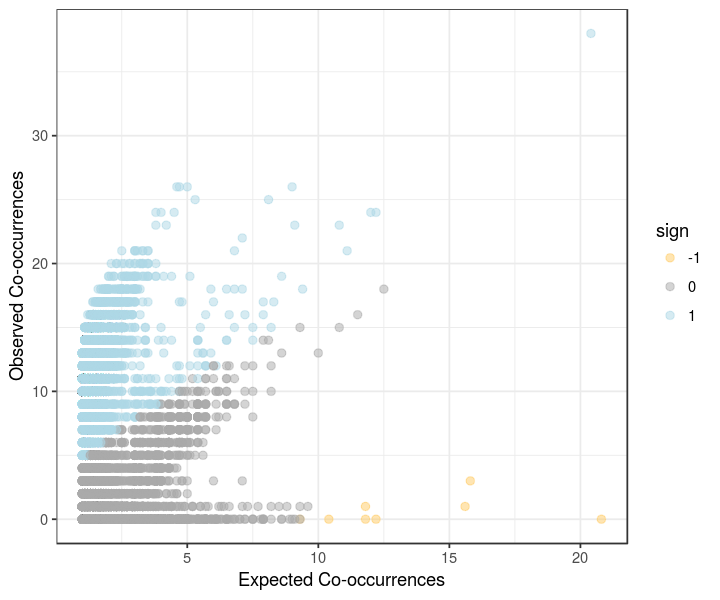

In [47]:
# plotting occurrences
p = ggplot(cooccur_res_s, aes(x = exp_cooccur, y = obs_cooccur)) + 
    geom_point(aes(color=sign), size=2, alpha=0.5) +
    scale_color_manual(values=c("#FFCC66", "dark gray", "light blue")) +
    labs(x="Expected Co-occurrences", y="Observed Co-occurrences") +
    theme_bw()

options(repr.plot.width=6, repr.plot.height=5)
plot(p)

In [48]:
# Summarizing by taxonomic group
cooccur_res_s_s = cooccur_res_s %>%
    group_by(Phylum.x, Phylum.y) %>%
    mutate(n_edges = n()) %>%
    group_by(Phylum.x, Phylum.y, sign) %>%
    summarize(n = n() / first(n_edges)) %>%
    ungroup() 

cooccur_res_s_s %>% status

[1] 71  4


Phylum.x,Phylum.y,sign,n
Actinobacteria,Bacteroidetes,0,1.00000000
Actinobacteria,Firmicutes,0,0.98333333
Actinobacteria,Firmicutes,1,0.01666667


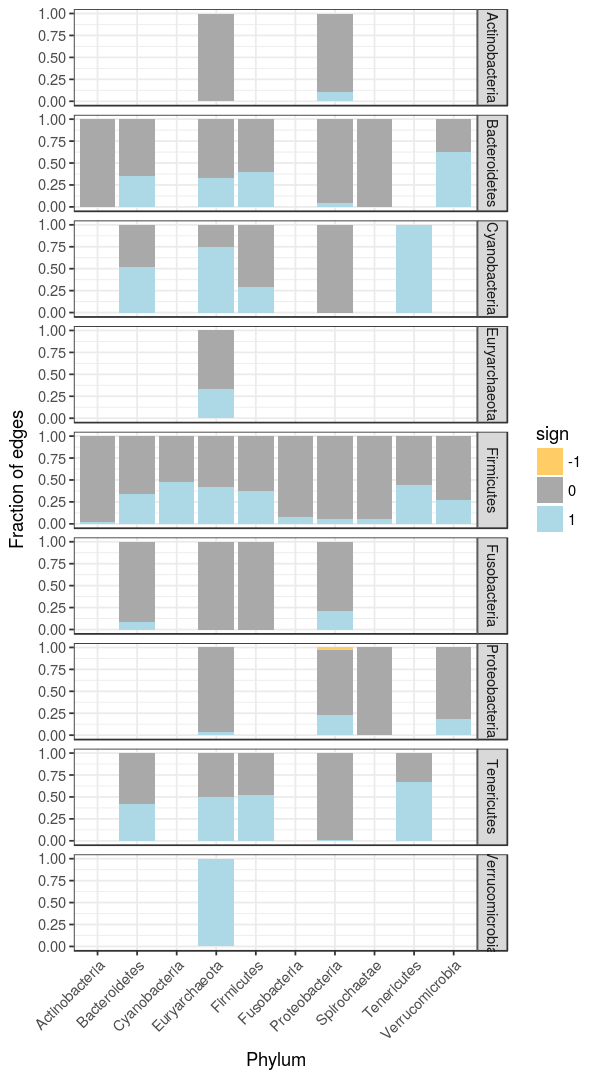

In [49]:
# Summarizing by domain
p = ggplot(cooccur_res_s_s, aes(Phylum.x, n, fill=sign)) +
    geom_bar(stat='identity') +
    scale_fill_manual(values=c("#FFCC66", "dark gray", "light blue")) +
    labs(x='Phylum', y='Fraction of edges') +
    facet_grid(Phylum.y ~ .) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=9)
plot(p)

# D3network

In [50]:
cooccur_res_s_f = cooccur_res_s %>%
    filter(sign != 0) %>%
    mutate(sp1_name = sp1_name %>% as.character,
           sp2_name = sp2_name %>% as.character)

cooccur_res_s_f %>% status

[1] 9332   29


sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,⋯,Genus.x,Species.x,Domain.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,effects
1,4,15,16,11,0.005,1.1,1,0,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,0.04669811
1,56,15,29,14,0.010,2.1,1,0,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,unclassified,0.05613208
1,57,15,17,12,0.006,1.2,1,0,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,uncultured bacterium,0.05094340


In [63]:
# checking 
cooccur_res_s_f %>%
    filter(q_lt < qval_cutoff | q_gt < qval_cutoff) %>%
    status

[1] 9332   29


sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,⋯,Genus.x,Species.x,Domain.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,effects
1,4,15,16,11,0.005,1.1,1,0,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,0.04669811
1,56,15,29,14,0.010,2.1,1,0,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,unclassified,0.05613208
1,57,15,17,12,0.006,1.2,1,0,368bd5c2255f3a5ce0fef06ca6de1d04,⋯,Methanobrevibacter,unclassified,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,uncultured bacterium,0.05094340


In [51]:
# node df
## creating df for node info
df1 = cooccur_res_s_f[,c('sp1_name', 'Domain.x', 'Phylum.x', 'Class.x', 'Order.x', 'Family.x', 'Genus.x')]
colnames(df1) = c('OTU', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus')

df2 = cooccur_res_s_f[,c('sp2_name', 'Domain.y', 'Phylum.y', 'Class.y', 'Order.y', 'Family.y', 'Genus.y')]
colnames(df2) = c('OTU', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus')

node_df = rbind(df1, df2) %>%
    distinct() %>%
    unite(taxonomy, c('Phylum', 'Class', 'Order', 'Family', 'Genus', 'OTU'), sep=';', remove=FALSE) %>%
    as.data.frame

# status
df1 = df2 = NULL
node_df %>% status

[1] 408   8


taxonomy,OTU,Domain,Phylum,Class,Order,Family,Genus
Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter;368bd5c2255f3a5ce0fef06ca6de1d04,368bd5c2255f3a5ce0fef06ca6de1d04,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter
Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter;779324e5648460c5a67e577c45131b42,779324e5648460c5a67e577c45131b42,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter
Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter;b918d185ee89a0b33d821ee766d76eb3,b918d185ee89a0b33d821ee766d76eb3,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter


In [52]:
# taxonomy
node_df %>% 
    group_by(Phylum, Class) %>%
    summarize(n=n()) %>%
    ungroup()

Phylum,Class,n
Actinobacteria,Actinobacteria,1
Bacteroidetes,Bacteroidia,53
Bacteroidetes,unclassified,1
Cyanobacteria,Melainabacteria,4
Euryarchaeota,Methanobacteria,5
Firmicutes,Bacilli,17
Firmicutes,Clostridia,281
Firmicutes,Erysipelotrichia,8
Firmicutes,Negativicutes,2
Fusobacteria,Fusobacteriia,3


In [53]:
# edge_df indexing by node_df
## OTUs in edge_df indexed by node_df row number (0-indexed)
otu_rename = data.frame(OTU = node_df$OTU,
                        OTU_idx = 0:(length(node_df$OTU)-1))

## summary
otu_rename$OTU_idx %>% summary
otu_rename %>% status

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   101.8   203.5   203.5   305.2   407.0 

[1] 408   2


OTU,OTU_idx
368bd5c2255f3a5ce0fef06ca6de1d04,0
779324e5648460c5a67e577c45131b42,1
b918d185ee89a0b33d821ee766d76eb3,2


In [54]:
# edge_df indexing by node_df
## OTUs in edge_df indexed by node_df row number (0-indexed)
edge_df = cooccur_res_s_f %>%
    inner_join(otu_rename, c('sp1_name'='OTU')) %>%
    inner_join(otu_rename, c('sp2_name'='OTU')) %>%
    mutate(sp1_name = sp1_name %>% as.Num,
           sp2_name = sp2_name %>% as.Num,
           edge_weight = abs(effects))

edge_df %>% status

Warning message:
“Column `sp1_name`/`OTU` joining character vector and factor, coercing into character vector”Warning message:
“Column `sp2_name`/`OTU` joining character vector and factor, coercing into character vector”Warning message in as.Num(.):
“NAs introduced by coercion”Warning message in as.Num(.):
“NAs introduced by coercion”

[1] 9332   32


sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,⋯,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,effects,OTU_idx.x,OTU_idx.y,edge_weight
1,4,15,16,11,0.005,1.1,1,0,NA,⋯,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,0.04669811,0,3,0.04669811
1,56,15,29,14,0.010,2.1,1,0,NA,⋯,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,unclassified,0.05613208,0,53,0.05613208
1,57,15,17,12,0.006,1.2,1,0,NA,⋯,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,uncultured bacterium,0.05094340,0,54,0.05094340


In [55]:
 # edge colors based on edge weight
edge_cols = ifelse(edge_df$effects > 0, "#339900", "#cc0000")
edge_cols %>% table

.
#339900 #cc0000 
   9324       8 

In [56]:
 # clickAction
MyClickScript = 'alert("Name: " + d.name + "\\nNode color group: " + d.group);'

In [57]:
# network
network_file = 'IndD_cooccur_ntwkd3.html'
forceNetwork(Links = edge_df, Nodes = node_df, 
             Source = "OTU_idx.x", Target = "OTU_idx.y",
             Value = "edge_weight", NodeID = "taxonomy", Group = "Family",
             fontSize=18, opacity = 0.8, zoom = TRUE, 
             linkWidth = JS("function(d) { return 20 * (d.value); }"),
             linkColour = edge_cols,
             clickAction = MyClickScript) %>% 
saveNetwork(file = network_file)
cat('File written:', network_file, '\n')

File written: IndD_cooccur_ntwkd3.html 


In [65]:
# load network html
#IRdisplay::display_html(paste("<iframe src=' ", network_file, " ' width = 100% height = 700 >"))

# sessionInfo

In [44]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_eco/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_eco/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2    cooccur_1.3     networkD3_0.4   phyloseq_1.22.3
[5] igraph_1.2.1    ggplot2_2.2.1   tidyr_0.7.1     dplyr_0.7.4    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.14        a